In [121]:
%load_ext autoreload
%autoreload 2

import torch
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

import matplotlib.pyplot as plt

from simclr.simclr import SimCLRLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


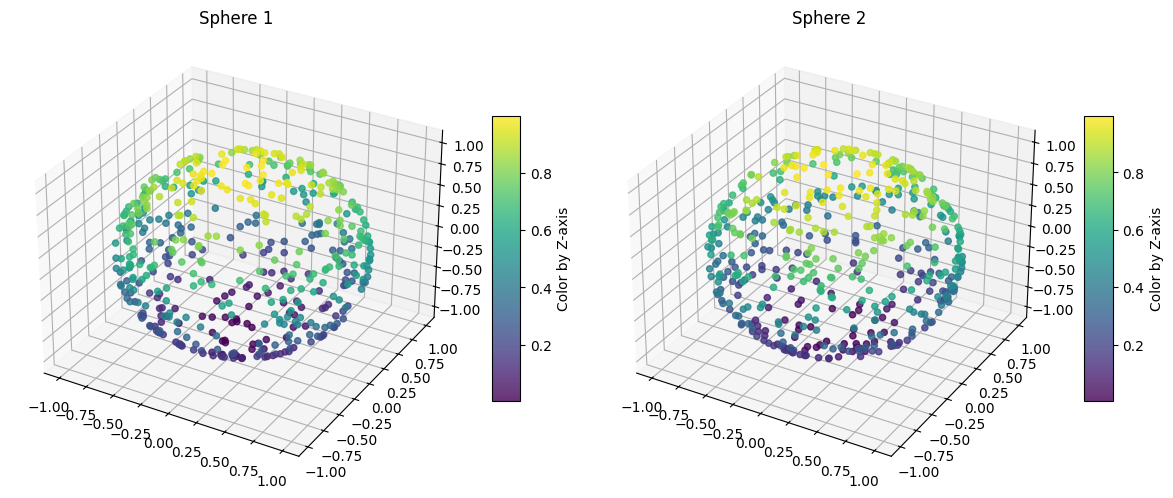

In [131]:
latent_dimension = 3 # Operate on a latent space dimension 3
data_dimension = 3 # Make data dimension identical
kappa = tau= 0.1 # Use 0.1 for kappa
normal_concentration_param = 0.05 # Default in Zimmerman's code

# Initialize a unit hypersphere of dimension 3
sphere = NSphereSpace(latent_dimension)

def sample_pairs(num_samples):
    z = sphere.uniform(num_samples)
    z_aug = sphere.von_mises_fisher(z, kappa, num_samples)

    return z, z_aug

def sample_neg(num_samples):
    return sphere.uniform(num_samples)

z, z_aug = sample_pairs(500)

visualize_spheres_side_by_side(plt, z, z_aug)

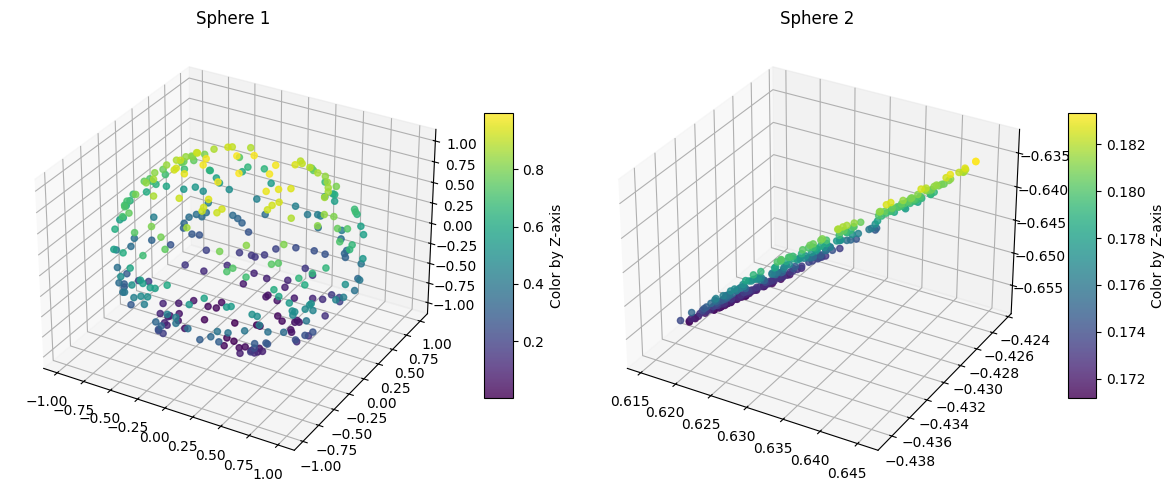

In [127]:
# Initialize data generation process
g = torch.nn.Identity()

# Initialize the multi-layer perceptron used for encoding
f = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

h = lambda z: f(g(z))

z = sphere.uniform(300)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723560333251953 Samples processed: 1
Loss: 8.722393989562988 Samples processed: 251
Loss: 8.722493171691895 Samples processed: 501
Loss: 8.722691535949707 Samples processed: 751
Loss: 8.722142219543457 Samples processed: 1001
Loss: 8.721902847290039 Samples processed: 1251
Loss: 8.72296142578125 Samples processed: 1501
Loss: 8.72244644165039 Samples processed: 1751


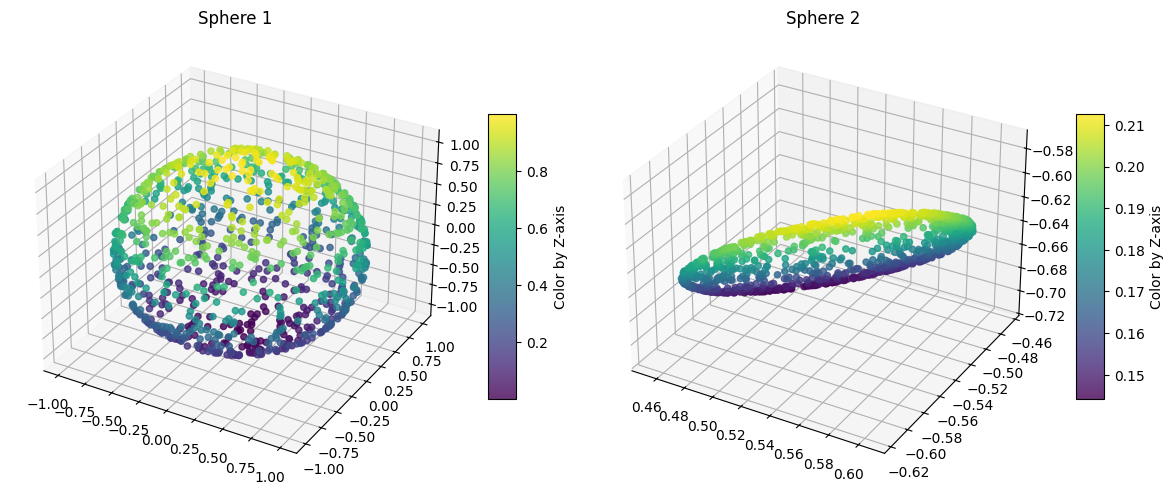

In [129]:
# Perform training

iterations = 2000
batch = 6144

adam = torch.optim.Adam(f.parameters(), lr=1e-4)
loss = SimCLRLoss(tau)

def training_step(z_enc, z_enc_sim, z_enc_neg, optimizer, loss):
    optimizer.zero_grad()

    z3 = torch.roll(z_enc, 1, 0)
    
    loss_result = loss(z_enc, z_enc_sim, z3)
    loss_result.backward()
    optimizer.step()

    return loss_result.item()

for i in range(iterations):
    z, z_sim = sample_pairs(batch)
    z_neg = sample_neg(batch)

    z_enc = h(z)
    z_enc_sim = h(z_sim)
    z_enc_neg = h(z_neg)

    loss_result = training_step(z_enc, z_enc_sim, z_enc_neg, adam, loss)

    if i % 250 == 1:
        print('Loss:', loss_result, 'Samples processed:', i)

z = sphere.uniform(1000)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z, z_enc)

Loss: 8.723039627075195 Samples processed: 1
Loss: 5.7839179039001465 Samples processed: 251
Loss: 5.761049270629883 Samples processed: 501
Loss: 5.7599778175354 Samples processed: 751
Loss: 5.758555889129639 Samples processed: 1001
Loss: 5.762094020843506 Samples processed: 1251
Loss: 5.757604122161865 Samples processed: 1501
Loss: 5.758952617645264 Samples processed: 1751


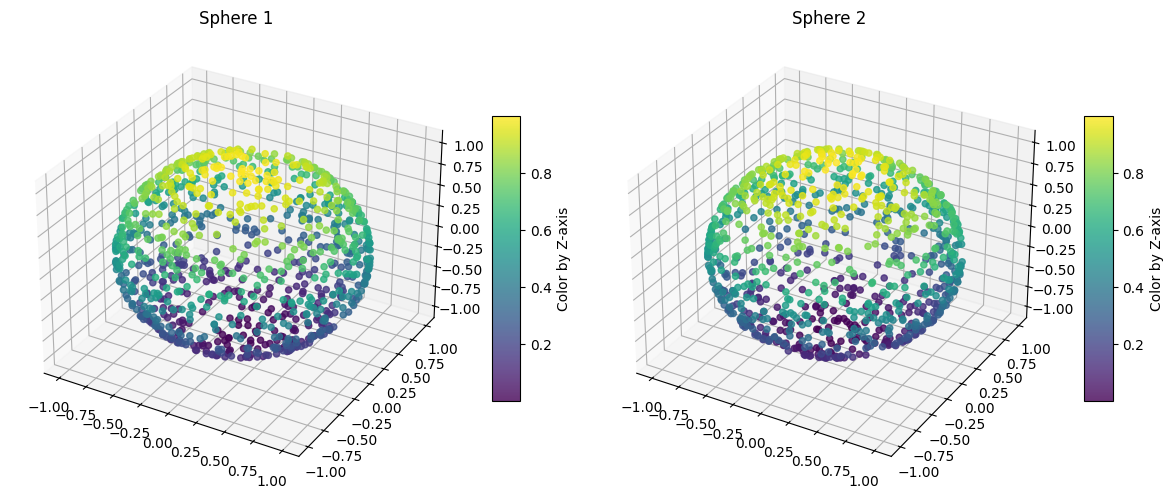

In [139]:
normal_concentration_param = 0.05

f_normal = get_mlp(
    n_in=data_dimension,
    n_out=latent_dimension,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

h_normal = lambda z: f_normal(g(z))

adam_normal = torch.optim.Adam(f_normal.parameters(), lr=1e-4)

loss_normal = SimCLRLoss(tau)

for i in range(iterations):
    z = sphere.uniform(batch)
    z_sim = sphere.normal(z, normal_concentration_param, batch) 
    z_neg = sphere.uniform(batch)
    z_enc = h_normal(z)
    z_enc_sim = h_normal(z_sim)
    z_enc_neg = h_normal(z_neg)
    loss_result = training_step(z_enc, z_enc_sim, z_enc_neg, adam_normal, loss_normal)
    
    if i % 250 == 1:
        print('Loss:', loss_result, 'Samples processed:', i)

z = sphere.uniform(1000)
z_enc = h_normal(z)
visualize_spheres_side_by_side(plt, z, z_enc)